## Importations

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from src.params import SUBJ_CLEAN, RESULT_PATH, ACTIVE_RUN, PASSIVE_RUN, FIG_PATH, FREQS_LIST, PREPROC_PATH, FREQS_NAMES
from src.utils import get_bids_file
import os
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt

import mne
from mne.channels import find_ch_adjacency, make_1020_channel_selections
from mne.viz import plot_compare_evokeds

## Prepare data

In [80]:
task = 'LaughterActive'
subj_list = SUBJ_CLEAN
stage = "epo"

# Select what conditions to compute (str)
cond1 = 'Good'
cond2 = 'BaselineZero'
cond3 = 'Miss'

if cond1 == 'Good' and 'cond3' == 'Miss' :
    button_cond = True
else :
    button_cond = False
    
conditions = conditions = cond1 + '-' + cond2
condition_list = [cond1, cond2]
picks = "meg" # Select MEG channels

roi = 'MLT'

In [81]:
# Import data

contrasts_all_subject = []
contrasts_all_subject_all_chan = []
evoked_baseline = []
evoked_condition1 = []

for subj in SUBJ_CLEAN :
    print("processing -->", subj)
    
    chan_selected = []
    
    # TODO : change with AR_epochs
    _, path_epochs = get_bids_file(RESULT_PATH, task=task, subj=subj, stage="AR_epo")
    epochs = mne.read_epochs(path_epochs, verbose=None)
    epochs.apply_baseline(baseline=(None, 0))
    
    CHAN = epochs.info['ch_names']
    
    for chan in CHAN  : 
        if roi in chan : 
            chan_selected.append(chan)
    
    epochs_copy = epochs.copy() 
    epochs_copy.pick_channels(chan_selected)
            
    #epochs_copy.filter(1, 20)
    
    # Take nb channel and time
    baseline_data = np.zeros((epochs_copy.get_data().shape[1], epochs_copy.get_data().shape[2]))
    baseline_roi = mne.EvokedArray(baseline_data, epochs_copy.info, tmin=-0.5, comment='baseline')
    
    baseline_data_all_chan = np.zeros((epochs.get_data().shape[1], epochs.get_data().shape[2]))
    baseline_all_chan = mne.EvokedArray(baseline_data_all_chan, epochs.info, tmin=-0.5, comment='baseline')
    
    # Compute button press : Combine cond1 & 2
    if button_cond == True : 
        evoked_cond1_roi = mne.combine_evoked([epochs_copy[cond1].average(), epochs_copy[cond3].average()], weights='nave')
        evoked_cond1_all_chan = mne.combine_evoked([epochs[cond1].average(), epochs[cond3].average()], weights='nave')

    else : 
        
        evoked_cond1_roi = epochs_copy[cond1].average()
        evoked_cond1_all_chan = epochs[cond1].average()

    evoked_baseline.append(baseline_roi) 
    evoked_condition1.append(evoked_cond1_roi)
    
    contrast = mne.combine_evoked([evoked_cond1_roi, baseline_roi], weights=[1, -1])
    contrast_all_chan = mne.combine_evoked([evoked_cond1_all_chan, baseline_all_chan], weights=[1, -1])
    contrast.pick_types(meg=True, ref_meg=False,  exclude='bads')
    
    contrasts_all_subject.append(contrast)
    contrasts_all_subject_all_chan.append(contrast_all_chan)
    
# Combine all subject together
evokeds = {cond1 : evoked_condition1, cond2 : evoked_baseline}

evoked_contrast = mne.combine_evoked(contrasts_all_subject, 'equal')
evoked_contrast_all_chan = mne.combine_evoked(contrasts_all_subject_all_chan, 'equal')


processing --> 01
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
296 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-02/sub-02_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
295 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-03/sub-03_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of in

Adding metadata with 7 columns
300 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing --> 22
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-22/sub-22_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
298 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing --> 23
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-23/sub-23_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
185 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
proce

## Perform paired t-test

In [63]:
# Perform t-test without correction without clusters
cond1_data = evoked_cond1_roi.get_data()
cond2_data = baseline_roi.get_data()

cond1_arr = np.transpose(cond1_data, [1, 0])
cond2_arr =  np.transpose(cond2_data, [1, 0])

print(cond1_arr.shape)
print(cond2_arr.shape)

report = "time={i_ti}, t({df})={t_val:.3f}, p={p:.3f}"
print("\nTargeted statistical test results:")

p_vals = []
x = []

for i_ti, ti in enumerate(cond1_arr):

    data1 = cond1_arr[i_ti, :]
    data2 = cond2_arr[i_ti, :]

    # conduct t test
    t, p = ttest_rel(data1, data2) # Paired t-test

    p_vals.append(p)
    x.append(i_ti)

    # display results
    format_dict = dict(
        i_ti=i_ti, df=len(cond1_arr) - 2, t_val=t, p=p
    )
    print(report.format(**format_dict))

(2401, 34)
(2401, 34)

Targeted statistical test results:
time=0, t(2399)=-8.729, p=0.000
time=1, t(2399)=-11.104, p=0.000
time=2, t(2399)=-12.460, p=0.000
time=3, t(2399)=-12.725, p=0.000
time=4, t(2399)=-12.230, p=0.000
time=5, t(2399)=-11.276, p=0.000
time=6, t(2399)=-10.102, p=0.000
time=7, t(2399)=-9.028, p=0.000
time=8, t(2399)=-8.446, p=0.000
time=9, t(2399)=-8.557, p=0.000
time=10, t(2399)=-9.111, p=0.000
time=11, t(2399)=-9.549, p=0.000
time=12, t(2399)=-9.518, p=0.000
time=13, t(2399)=-9.081, p=0.000
time=14, t(2399)=-8.484, p=0.000
time=15, t(2399)=-8.034, p=0.000
time=16, t(2399)=-8.106, p=0.000
time=17, t(2399)=-9.069, p=0.000
time=18, t(2399)=-11.026, p=0.000
time=19, t(2399)=-13.252, p=0.000
time=20, t(2399)=-14.077, p=0.000
time=21, t(2399)=-13.113, p=0.000
time=22, t(2399)=-11.557, p=0.000
time=23, t(2399)=-10.162, p=0.000
time=24, t(2399)=-9.074, p=0.000
time=25, t(2399)=-8.205, p=0.000
time=26, t(2399)=-7.408, p=0.000
time=27, t(2399)=-6.655, p=0.000
time=28, t(2399)

time=466, t(2399)=-1.755, p=0.089
time=467, t(2399)=-2.421, p=0.021
time=468, t(2399)=-2.536, p=0.016
time=469, t(2399)=-1.846, p=0.074
time=470, t(2399)=-0.529, p=0.600
time=471, t(2399)=0.760, p=0.453
time=472, t(2399)=1.549, p=0.131
time=473, t(2399)=1.726, p=0.094
time=474, t(2399)=1.296, p=0.204
time=475, t(2399)=0.320, p=0.751
time=476, t(2399)=-0.962, p=0.343
time=477, t(2399)=-2.137, p=0.040
time=478, t(2399)=-2.813, p=0.008
time=479, t(2399)=-2.707, p=0.011
time=480, t(2399)=-1.653, p=0.108
time=481, t(2399)=0.017, p=0.986
time=482, t(2399)=1.447, p=0.157
time=483, t(2399)=2.096, p=0.044
time=484, t(2399)=1.858, p=0.072
time=485, t(2399)=0.981, p=0.334
time=486, t(2399)=0.107, p=0.916
time=487, t(2399)=-0.332, p=0.742
time=488, t(2399)=-0.296, p=0.769
time=489, t(2399)=0.096, p=0.924
time=490, t(2399)=0.491, p=0.626
time=491, t(2399)=0.025, p=0.980
time=492, t(2399)=-1.580, p=0.124
time=493, t(2399)=-3.471, p=0.001
time=494, t(2399)=-5.053, p=0.000
time=495, t(2399)=-6.025, p=

time=930, t(2399)=2.528, p=0.016
time=931, t(2399)=3.036, p=0.005
time=932, t(2399)=4.624, p=0.000
time=933, t(2399)=6.118, p=0.000
time=934, t(2399)=6.523, p=0.000
time=935, t(2399)=6.243, p=0.000
time=936, t(2399)=5.501, p=0.000
time=937, t(2399)=4.280, p=0.000
time=938, t(2399)=2.737, p=0.010
time=939, t(2399)=1.188, p=0.243
time=940, t(2399)=-0.168, p=0.867
time=941, t(2399)=-1.228, p=0.228
time=942, t(2399)=-1.748, p=0.090
time=943, t(2399)=-1.575, p=0.125
time=944, t(2399)=-1.058, p=0.298
time=945, t(2399)=-0.499, p=0.621
time=946, t(2399)=0.056, p=0.956
time=947, t(2399)=0.639, p=0.527
time=948, t(2399)=1.293, p=0.205
time=949, t(2399)=2.135, p=0.040
time=950, t(2399)=3.385, p=0.002
time=951, t(2399)=4.830, p=0.000
time=952, t(2399)=4.883, p=0.000
time=953, t(2399)=4.000, p=0.000
time=954, t(2399)=3.368, p=0.002
time=955, t(2399)=3.073, p=0.004
time=956, t(2399)=2.964, p=0.006
time=957, t(2399)=2.742, p=0.010
time=958, t(2399)=2.309, p=0.027
time=959, t(2399)=2.036, p=0.050
time

time=1397, t(2399)=-0.856, p=0.398
time=1398, t(2399)=-1.363, p=0.182
time=1399, t(2399)=-1.999, p=0.054
time=1400, t(2399)=-2.551, p=0.016
time=1401, t(2399)=-2.800, p=0.008
time=1402, t(2399)=-2.658, p=0.012
time=1403, t(2399)=-2.230, p=0.033
time=1404, t(2399)=-1.714, p=0.096
time=1405, t(2399)=-1.325, p=0.194
time=1406, t(2399)=-1.235, p=0.226
time=1407, t(2399)=-1.504, p=0.142
time=1408, t(2399)=-2.069, p=0.046
time=1409, t(2399)=-2.782, p=0.009
time=1410, t(2399)=-3.429, p=0.002
time=1411, t(2399)=-3.760, p=0.001
time=1412, t(2399)=-3.672, p=0.001
time=1413, t(2399)=-3.347, p=0.002
time=1414, t(2399)=-3.070, p=0.004
time=1415, t(2399)=-3.036, p=0.005
time=1416, t(2399)=-3.305, p=0.002
time=1417, t(2399)=-3.819, p=0.001
time=1418, t(2399)=-4.442, p=0.000
time=1419, t(2399)=-5.002, p=0.000
time=1420, t(2399)=-5.355, p=0.000
time=1421, t(2399)=-5.420, p=0.000
time=1422, t(2399)=-5.232, p=0.000
time=1423, t(2399)=-4.951, p=0.000
time=1424, t(2399)=-4.799, p=0.000
time=1425, t(2399)=-

time=1868, t(2399)=-5.037, p=0.000
time=1869, t(2399)=-5.110, p=0.000
time=1870, t(2399)=-4.745, p=0.000
time=1871, t(2399)=-4.233, p=0.000
time=1872, t(2399)=-3.931, p=0.000
time=1873, t(2399)=-4.007, p=0.000
time=1874, t(2399)=-4.495, p=0.000
time=1875, t(2399)=-5.362, p=0.000
time=1876, t(2399)=-6.512, p=0.000
time=1877, t(2399)=-7.699, p=0.000
time=1878, t(2399)=-8.405, p=0.000
time=1879, t(2399)=-8.051, p=0.000
time=1880, t(2399)=-6.712, p=0.000
time=1881, t(2399)=-5.030, p=0.000
time=1882, t(2399)=-3.464, p=0.001
time=1883, t(2399)=-2.166, p=0.038
time=1884, t(2399)=-1.180, p=0.246
time=1885, t(2399)=-0.547, p=0.588
time=1886, t(2399)=-0.320, p=0.751
time=1887, t(2399)=-0.533, p=0.597
time=1888, t(2399)=-1.156, p=0.256
time=1889, t(2399)=-2.037, p=0.050
time=1890, t(2399)=-2.908, p=0.006
time=1891, t(2399)=-3.589, p=0.001
time=1892, t(2399)=-4.087, p=0.000
time=1893, t(2399)=-4.471, p=0.000
time=1894, t(2399)=-4.767, p=0.000
time=1895, t(2399)=-4.938, p=0.000
time=1896, t(2399)=-

time=2330, t(2399)=-4.831, p=0.000
time=2331, t(2399)=-4.796, p=0.000
time=2332, t(2399)=-4.156, p=0.000
time=2333, t(2399)=-2.655, p=0.012
time=2334, t(2399)=-0.545, p=0.589
time=2335, t(2399)=1.596, p=0.120
time=2336, t(2399)=3.379, p=0.002
time=2337, t(2399)=4.509, p=0.000
time=2338, t(2399)=4.462, p=0.000
time=2339, t(2399)=2.992, p=0.005
time=2340, t(2399)=0.897, p=0.376
time=2341, t(2399)=-1.063, p=0.296
time=2342, t(2399)=-2.736, p=0.010
time=2343, t(2399)=-3.871, p=0.000
time=2344, t(2399)=-3.634, p=0.001
time=2345, t(2399)=-2.360, p=0.024
time=2346, t(2399)=-1.212, p=0.234
time=2347, t(2399)=-0.431, p=0.669
time=2348, t(2399)=0.064, p=0.949
time=2349, t(2399)=0.316, p=0.754
time=2350, t(2399)=0.284, p=0.778
time=2351, t(2399)=-0.082, p=0.935
time=2352, t(2399)=-0.730, p=0.470
time=2353, t(2399)=-1.542, p=0.133
time=2354, t(2399)=-2.333, p=0.026
time=2355, t(2399)=-2.850, p=0.007
time=2356, t(2399)=-2.972, p=0.005
time=2357, t(2399)=-2.759, p=0.009
time=2358, t(2399)=-2.327, p=

In [66]:
# Select pvalues sig.
pval_corrected = 0.01/len(cond1_arr) #Number of time point
pval_plot = []
time_plot = []
for i, pval in enumerate(p_vals) : 
    if pval < pval_corrected :
        pval_plot.append(pval)
        time_plot.append(x[i])

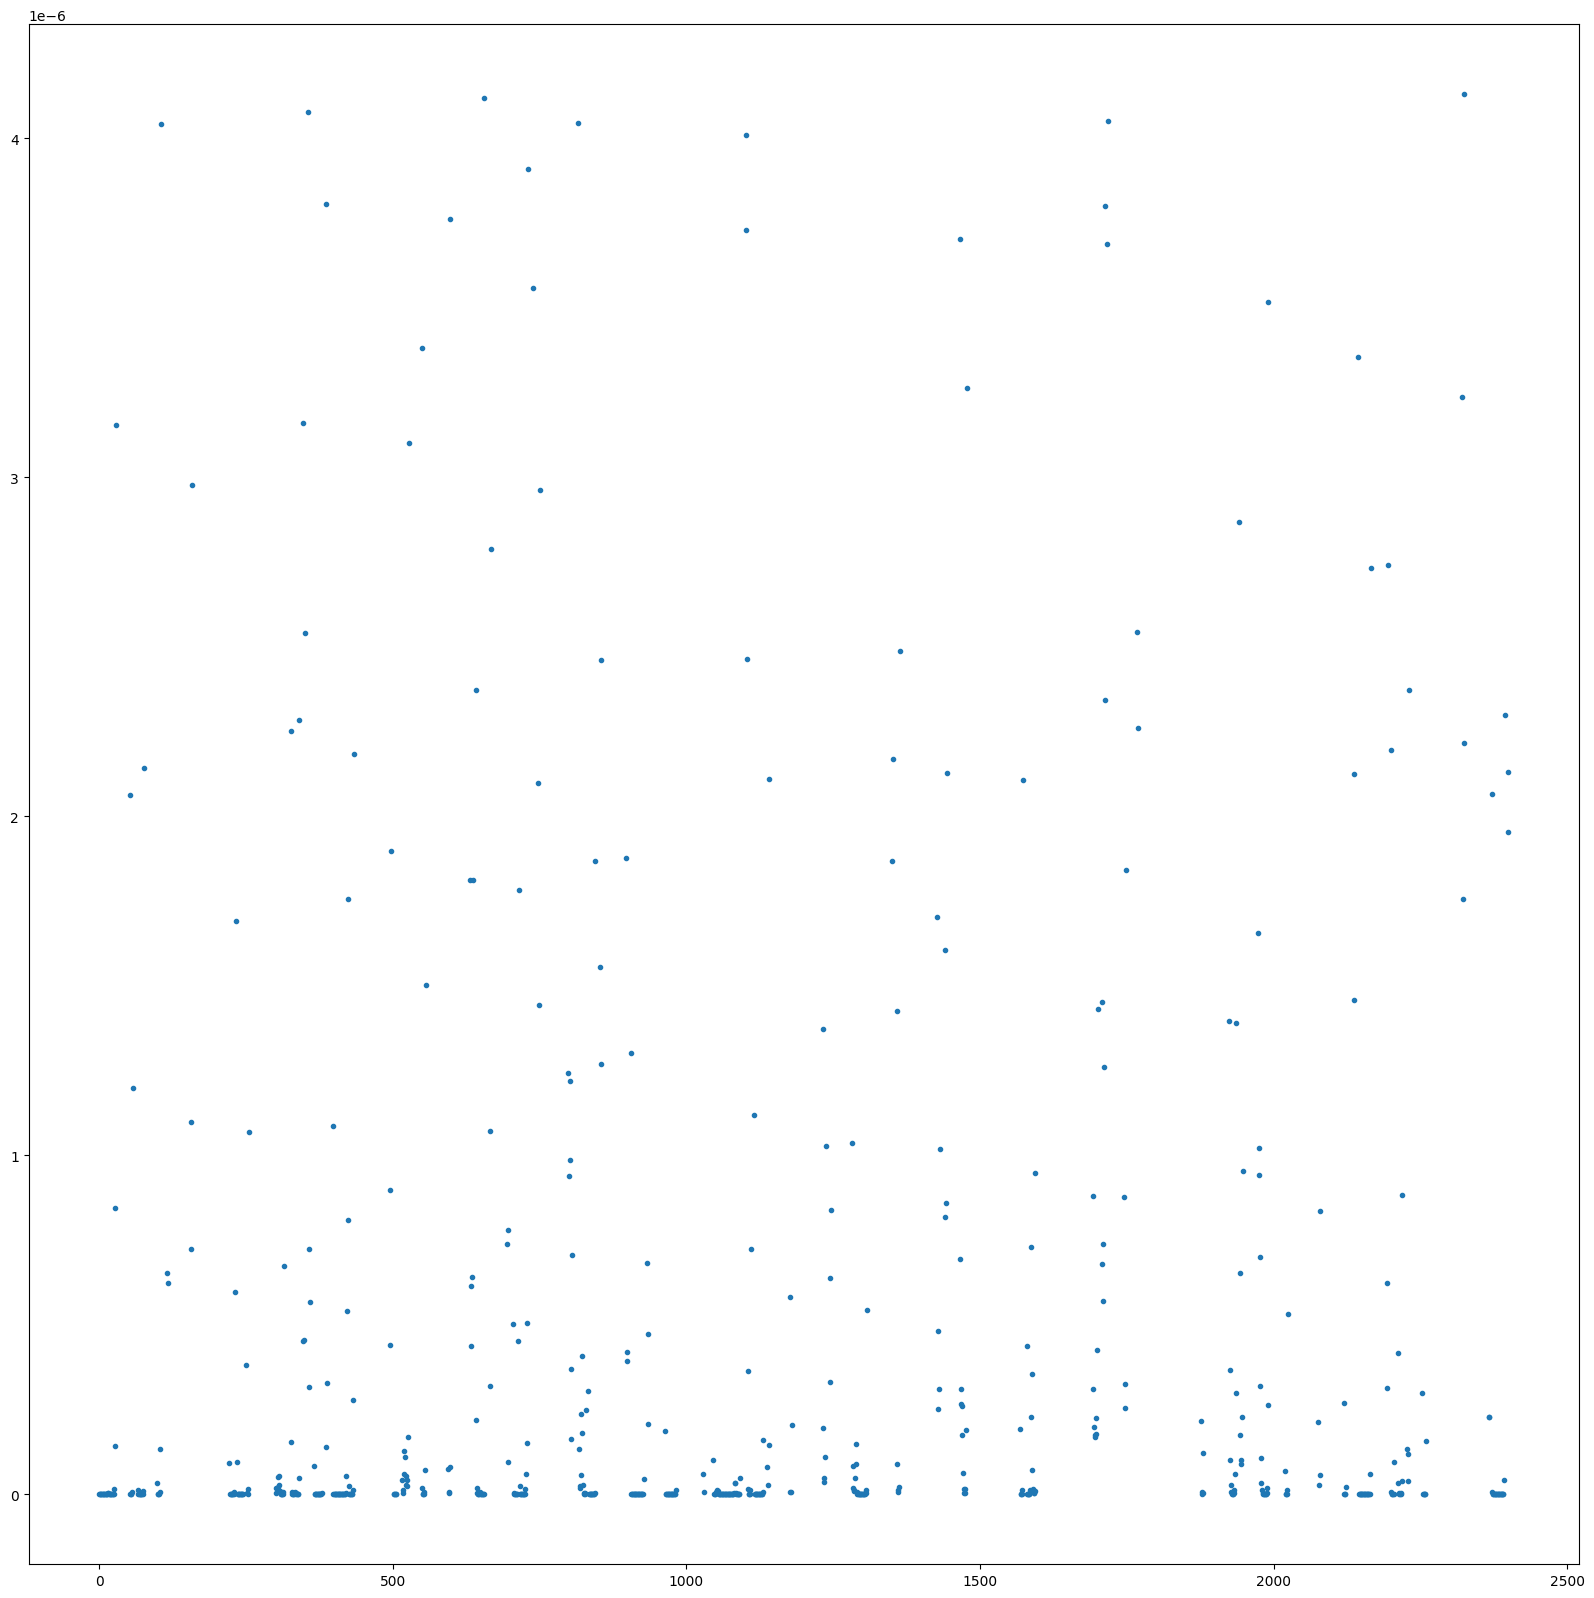

In [67]:
# Plot pvals sig through time
y = np.array(pval_plot)
x_plot = np.array(time_plot)

fig, ax = plt.subplots(1, figsize=(20, 20))
plt.plot(x_plot, y, marker='.', linestyle='None')
plt.show()

## Plot

combining channels using "mean"
combining channels using "mean"


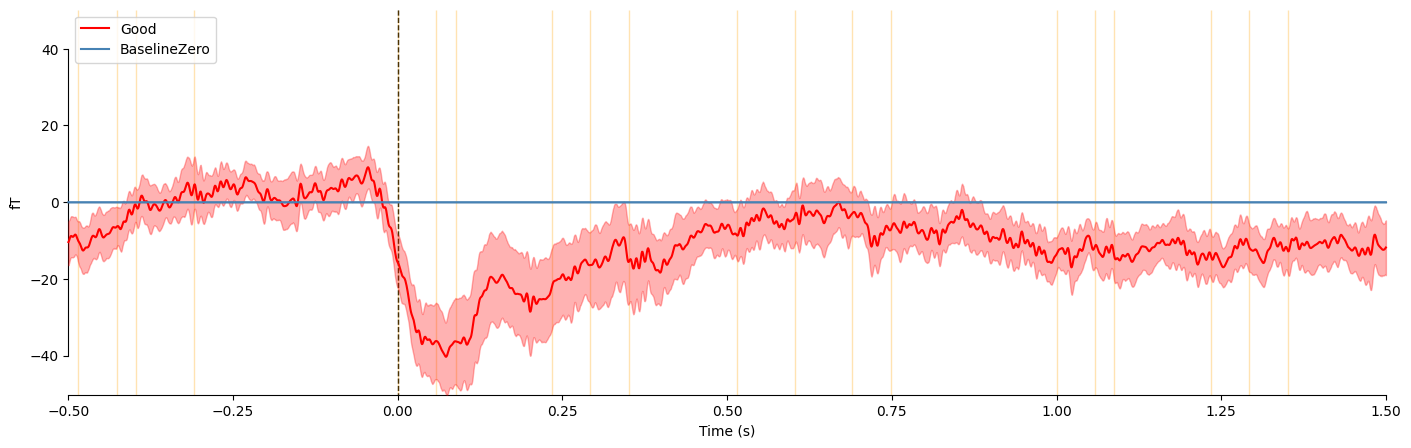

In [84]:
colors = "r",'steelblue'

fig, ax = plt.subplots(1, 1, figsize=(17, 5))

plot_compare_evokeds(evokeds,
                colors=colors, show=False, axes=ax,
                split_legend=True, truncate_yaxis='auto', combine="mean")

for i, val in enumerate(pval_plot):
    sig_times = []
    
    # plot temporal cluster extent
    sig_times.append(time_plot[i])
    ymin, ymax = ax.get_ylim()
    ax.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                        color='orange', alpha=0.3)
plt.show()